In [1]:
import numpy as np
import pandas as pd
import scanpy as sc 
import scirpy as ir
import muon as mu

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


In [4]:
mdata = mu.read("/Users/jerryaaaaaa/clonal_label.h5mu")

/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


Drop cells with NA clonal_dynamic labeling

In [5]:
valid_cells = mdata["airr"].obs[~mdata["airr"].obs["clonal_dynamic_label"].isna()].index
mdata_filtered = mdata[valid_cells].copy()
mdata_filtered["gex"].obs["clonal_dynamic_label"] = mdata_filtered["airr"].obs["clonal_dynamic_label"]
mdata_filtered["gex"].obs["clonal_dynamic"] = mdata_filtered["airr"].obs["clonal_dynamic"]
mdata_filtered["gex"].obs["clone_id"] = mdata_filtered["airr"].obs["clone_id"]

Add TCR info to ["airr"].obs & ["gex"].obs

In [6]:
cdr3_info = ir.get.airr(
    mdata_filtered["airr"],
    airr_variable=["cdr3_aa"],
    chain=["VJ_1", "VDJ_1"]
)
mdata_filtered["airr"].obs["alpha_cdr3_aa"] = cdr3_info["VJ_1_cdr3_aa"]
mdata_filtered["airr"].obs["beta_cdr3_aa"] = cdr3_info["VDJ_1_cdr3_aa"]
mdata_filtered["gex"].obs["alpha_cdr3_aa"] = cdr3_info["VJ_1_cdr3_aa"]
mdata_filtered["gex"].obs["beta_cdr3_aa"] = cdr3_info["VDJ_1_cdr3_aa"]

Extract TCR_CDR3 sequence length

In [7]:
mdata_filtered["airr"].obs["alpha_cdr3_len"] = mdata_filtered["airr"].obs["alpha_cdr3_aa"].apply(lambda x: len(x) if isinstance(x, str) else 0)
mdata_filtered["airr"].obs["beta_cdr3_len"] = mdata_filtered["airr"].obs["beta_cdr3_aa"].apply(lambda x: len(x) if isinstance(x, str) else 0)
mdata_filtered["gex"].obs["alpha_cdr3_len"] = mdata_filtered["airr"].obs["alpha_cdr3_aa"].apply(lambda x: len(x) if isinstance(x, str) else 0)
mdata_filtered["gex"].obs["beta_cdr3_len"] = mdata_filtered["airr"].obs["beta_cdr3_aa"].apply(lambda x: len(x) if isinstance(x, str) else 0)

Per-cell Leiden cluster ----> Reactivity Proxy

In [8]:
mdata_filtered["gex"].obs["phenotype_label"] = mdata_filtered["gex"].obs["leiden"].map({
    "2": "Reactive",
    "0": "Nonreactive",
    "1": "Nonreactive",
    "3": "Nonreactive",
    "4": "Nonreactive",
    "5": "Nonreactive",
})

In [9]:
clonal_reactivity = (
    mdata_filtered["gex"].obs.groupby("clone_id")["phenotype_label"]
    .agg(lambda x: "Reactive" if "Reactive" in x.values else "Nonreactive")
)

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_42630/1770967857.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdata_filtered["gex"].obs.groupby("clone_id")["phenotype_label"]


In [10]:
mdata_filtered["gex"].obs["reactivity_label"] = (
    mdata_filtered["gex"].obs["clone_id"].map(clonal_reactivity)
)

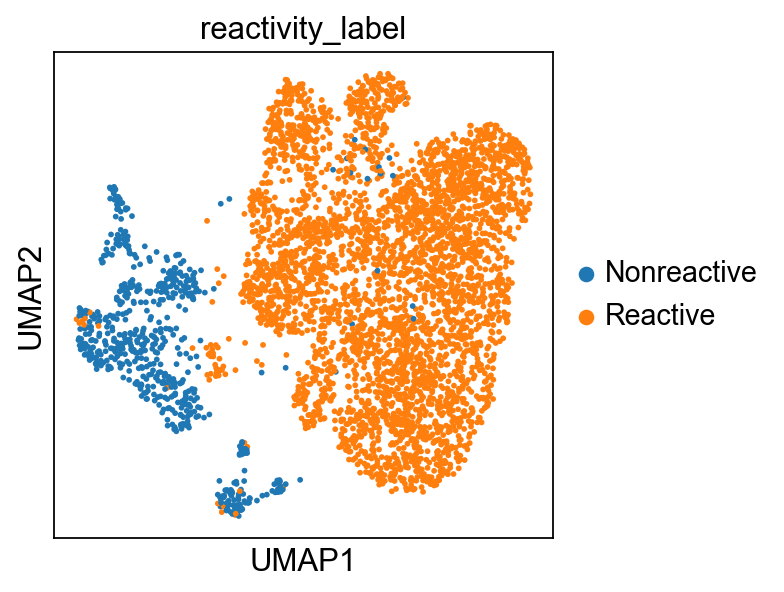

In [11]:
sc.pl.umap(mdata_filtered["gex"], color="reactivity_label")

Extract cells_id for train/test split

Stratify = labels(targets) ensures the proportion of each class is preserved in both train and test sets

In [12]:
cell_ids = mdata_filtered.obs_names
labels = mdata_filtered["gex"].obs["reactivity_label"]

train_cells, test_cells = train_test_split(
    cell_ids,
    test_size=0.3,
    random_state=42,
    stratify=labels
)
mdata_train = mdata_filtered[train_cells].copy()
mdata_test = mdata_filtered[test_cells].copy()

DEGs on training set (Reactive vs Nonreactive)

In [13]:
sc.tl.rank_genes_groups(mdata_train["gex"], groupby="reactivity_label", groups=["Reactive"], reference="Nonreactive", method="wilcoxon")

ranking genes


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [15]:
deg_df = sc.get.rank_genes_groups_df(mdata_train["gex"], group="Reactive")
deg_df_filtered = deg_df[deg_df["pvals_adj"] < 0.05]
feature_genes = deg_df_filtered["names"].unique().tolist()

In [16]:
gex_train = mdata_train["gex"].to_df()[feature_genes]
gex_test = mdata_test["gex"].to_df()[feature_genes]

In [19]:
tcr_train = mdata_train["gex"].obs[["alpha_cdr3_len", "beta_cdr3_len", "clonal_dynamic_label"]]
tcr_test = mdata_test["gex"].obs[["alpha_cdr3_len", "beta_cdr3_len", "clonal_dynamic_label"]]

In [20]:
X_train = pd.concat([gex_train, tcr_train], axis=1)
X_test = pd.concat([gex_test, tcr_test], axis=1)